<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: ???? </center></h4>
<h4><center> Filename: assignment_1_XX.ipynb where XX is your group number</center></h4>
<h4><center> Group Member 1: Student Name, Student ID </center></h4>
<h4><center> Group Member 2: Student Name, Student ID </center></h4>
<h4><center> Group Member 3: Student Name, Student ID </center></h4>
<h4><center> Group Member 4: Student Name, Student ID </center></h4>

**Remark:** as described below, each group has to submit two documents on lumiNUS: 
1. a jupyter notebook with your code  
2. a pdf report explaining your approaches and conclusions.
3. you can have a look at `https://www.overleaf.com/read/xmvqgpsdqwyx` if you would like to use Overleaf and Latex to rapidly produce a neat report. You can use your NUS email to create an Overleaf account.

**File naming convention:**
1. the Jupyter notebook needs to be named `assignment_1_XX.ipynb`. For example, group number 3 needs to name its jupyter notebook as `assignment_1_03.ipynb`.
1. the pdf report needs to be named `assignment_1_XX.pdf`. For example, group number 3 needs to name its pdf report as `assignment_1_03.pdf`.



**To load data on Google Colab**:
1. Upload the data onto your Google Drive
2. Run the first cell to log in your Google account and mount on your Google Drive
3. Change *path_csv* and *path* accordingly

In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [12]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as jnp
import numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time

In [2]:
#load attributes csv file
path_csv  = "D:\\Academics\\DSA\\4212\\datasets" # Local Path (Change Here)
# path_csv  = '/content/gdrive/My Drive/DSA4212/datasets' # Google Drive
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))


In [3]:
#let us list all the files in the image directory
path = "D:\\Academics\\DSA\\4212\\datasets\\img_celeba_small" # Local Path (Change Here)
# path = "/content/gdrive/My Drive/DSA4212/datasets/img_celeba_small" # Google Drive
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


## Import Data
### Notice: Images are only loaded as file names at this stage, to read as numerical arrays, use image_loader/image_loader_fname

In [14]:
# Proportion of Males in first 15000? first 200?
train_img = all_img[:15000]
train_attr = attribute.drop(columns=['Filename' ,'Male'])[:15000]
train_label = attribute['Male'][:15000]
train_label = np.array(train_label).reshape(-1,1)

test_img = all_img[15000:]
test_attr = attribute.drop(columns=['Filename' ,'Male'])[15000:]
test_label = attribute['Male'][15000:]
test_label = np.array(test_label).reshape(-1,1)

train_small_img = all_img[:200]
train_small_attr = attribute.drop(columns=['Filename' ,'Male'])[:200]
train_small_label = attribute['Male'][:200]
train_small_label = np.array(train_small_label).reshape(-1,1)

## Common Utility Functions

In [41]:
# #let us load the first 500 images
# n_img = 500
# img_array = onp.zeros((n_img, 100,100))
# for k in range(n_img):
#     im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
#     im = resize(im, (100,100) )
#     im = onp.mean(im, axis=2) # average the last channel
#     img_array[k,:,:] = im
    
def image_loader(indices, res, grey=False):
    """
    Load Images

    args:
    indices: indices of the image to be loaded
    res: resolution of the image, an iterable of size 2
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images).
    """
    if grey == True:
        img_array = onp.zeros((indices.size, res[0], res[1]))
        i = 0
        for k in indices:
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = resize(im, (3, res[0],res[1]) )
            im = onp.mean(im, axis=2) # average the last channel
            img_array[i,:,:] = im
            i += 1
    else:
        img_array = onp.zeros((indices.size, 3, res[0], res[1]))
        i = 0
        for k in indices:
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = resize(im, (res[0],res[1]) )
            img_array[i,:,:,:] = im
            i += 1
        
    return img_array

def image_loader_fname(fnames, res, grey=False):
    """
    Load Images by File Names

    args:
    fnames: file names of the image to be loaded (a list)
    res: resolution of the image, an iterable of size 2
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images).
    """
    if grey == True:
        img_array = onp.zeros((len(fnames), res[0], res[1]))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (res[0],res[1]) )
            im = onp.mean(im, axis=2) # average the last channel
            img_array[i,:,:] = im
            i += 1
    else:
        img_array = onp.zeros((len(fnames), 3, res[0], res[1]))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (3,res[0],res[1]) )
            img_array[i,:,:,:] = im
            i += 1
            
    return img_array

In [27]:
@jax.jit
def get_label(p, threshold=0.5):
    pred_bool = p > threshold
    pred_label = 2*pred_bool - 1
    return pred_label

def get_accuracy(p, Y):
    """ Compare the predicted probability (p) with the ground truth labels (Y) to get the accuracy """
    return jnp.mean(Y==get_label(p))

from sklearn.metrics import roc_auc_score

def get_auc(p, Y):
    return roc_auc_score(p, Y)

In [28]:
def test_acc_auc(beta, Y_true, test_img_arr):
    """
    Get the accuracy and AUC-ROC score for test data
     beta: Model Parameters
     Y_true: Ground truth labels
     test_img_arr: test images represented by an array
    """
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_acc = get_accuracy(test_pred, Y_true)
    test_auc = get_auc(Y_true, test_pred)
    
    return test_acc, test_auc

## Utility Functions for Basic Logistic Regression

In [6]:
@jax.jit
def loss_single(beta, x, y):
    """ logistic regression loss on a single image """
    return jnp.log(1. + jnp.exp(-y*jnp.dot(x,beta)))
loss_batch = jax.vmap(loss_single, in_axes=(None, 0, 0)) # Vectorize Loss Function

In [7]:
@jax.jit
def pred_proba(beta, x):
    """ predict the probability that label is +1 given x and beta """
    return 1 / (1 + jnp.exp(-jnp.dot(beta, x)))

pred_proba_batch = jax.vmap(pred_proba, in_axes=(None, 0)) # Vectorize Predict Function

In [8]:
@jax.jit
def loss_LR(beta, X, Y):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    # compute all the individual losses
    losses = loss_batch(beta, X, Y)
    return jnp.mean(losses)

# compute derivates
loss_LR_grad = jax.jit(jax.grad(loss_LR, argnums=0))
loss_LR_values_and_grad = jax.jit(jax.value_and_grad(loss_LR, argnums=0))

## Utility Functions for Regularized Logistic Regression (Ridge, Lasso, ...)

In [ ]:
### To be completed...

## Basic SGD

In [10]:
# initialize beta at random
np.random.seed(42)
pixels = 100
res = [pixels, pixels]
beta_standard_dev = 1. / pixels
beta_init = np.random.normal(0,beta_standard_dev,pixels*pixels)

In [23]:
test_img_arr = image_loader_fname(test_img, res, True)
test_img_arr = test_img_arr.reshape(len(test_img), res[0]*res[1])

In [15]:
n_epoch = 10
minibatch_size = 100 #size of the minibatchs
N = len(train_img)  #15000, total number of images
img_indices = np.arange(N)

loss_history = []
loss_history_end_epoch = []
beta = np.copy(beta_init)
learning_rate = 1e-6

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    start = time.time()
    n_minibatch = N // minibatch_size + 1
    # randomize the batches
    np.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = image_loader(batch_indices, res, True)
        X_minibatch = X_minibatch.reshape(minibatch_size, pixels*pixels)
        Y_minibatch = train_label[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta = beta - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
    end = time.time()
    duration = end - start
    print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}")

Epoch 0: 189.71 seconds, Loss: 12.67
Epoch 1: 121.56 seconds, Loss: 8.96
Epoch 2: 114.33 seconds, Loss: 7.55
Epoch 3: 113.49 seconds, Loss: 7.29
Epoch 4: 117.00 seconds, Loss: 6.50
Epoch 5: 117.24 seconds, Loss: 6.36
Epoch 6: 129.52 seconds, Loss: 5.72
Epoch 7: 128.79 seconds, Loss: 5.51
Epoch 8: 113.53 seconds, Loss: 5.33
Epoch 9: 105.47 seconds, Loss: 5.39


KeyboardInterrupt: 

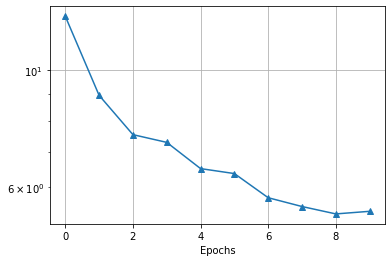

In [16]:
plt.plot(loss_history_end_epoch, "-^")
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)

In [29]:
acc_test, auc_test = test_acc_auc(beta, test_label, test_img_arr)

print(f'Test Accuracy is {acc_test:.2f}')
print(f'Test AUC is {auc_test:.2f}')

Test Accuracy is 0.52
Test AUC is 0.78


## Annealing

### Step Decay

In [36]:
# initialize beta at random
np.random.seed(42)
pixels = 100
res = [pixels, pixels]
beta_standard_dev = 1. / pixels
beta_init = np.random.normal(0,beta_standard_dev,pixels*pixels)

In [37]:
n_epoch = 10
minibatch_size = 100 #size of the minibatchs
N = len(train_img)  #15000, total number of images
img_indices = np.arange(N)

loss_history = []
loss_history_end_epoch = []
beta = np.copy(beta_init)
learning_rate = 1e-6
lr_decay = 0.5

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    start = time.time()
    n_minibatch = N // minibatch_size + 1
    # randomize the batches
    np.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = image_loader(batch_indices, res, True)
        X_minibatch = X_minibatch.reshape(minibatch_size, pixels*pixels)
        Y_minibatch = train_label[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta = beta - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
    end = time.time()
    duration = end - start
    if (epoch + 1) % 5 == 0:
        learning_rate = learning_rate * lr_decay
    test_acc, _ = test_acc_auc(beta, test_label, test_img_arr)
    print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Test Accuracy: {test_acc:.3f}")

Epoch 0: 139.09 seconds, Loss: 12.49, Test Accuracy: 0.511
Epoch 1: 104.11 seconds, Loss: 8.53, Test Accuracy: 0.524
Epoch 2: 109.37 seconds, Loss: 7.69, Test Accuracy: 0.516
Epoch 3: 108.27 seconds, Loss: 7.09, Test Accuracy: 0.522
Epoch 4: 108.43 seconds, Loss: 6.56, Test Accuracy: 0.510
Epoch 5: 156.51 seconds, Loss: 6.21, Test Accuracy: 0.514
Epoch 6: 130.45 seconds, Loss: 5.89, Test Accuracy: 0.514
Epoch 7: 143.99 seconds, Loss: 5.73, Test Accuracy: 0.519
Epoch 8: 144.31 seconds, Loss: 5.58, Test Accuracy: 0.519
Epoch 9: 169.67 seconds, Loss: 5.45, Test Accuracy: 0.508


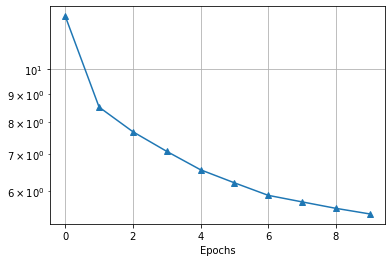

In [39]:
plt.plot(loss_history_end_epoch, "-^")
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)

In [40]:
acc_test, auc_test = test_acc_auc(beta, test_label, test_img_arr)

print(f'Test Accuracy is {acc_test:.2f}')
print(f'Test AUC is {auc_test:.2f}')

Test Accuracy is 0.51
Test AUC is 0.74


### Heuristic

In [31]:
# initialize beta at random
np.random.seed(42)
pixels = 100
res = [pixels, pixels]
beta_standard_dev = 1. / pixels
beta_init = np.random.normal(0,beta_standard_dev,pixels*pixels)

In [30]:
# Create Validation Set for Heuristic
valid_img = all_img[14000:15000]
valid_img_arr = image_loader_fname(valid_img, res, True)
valid_img_arr = valid_img_arr.reshape(len(valid_img), res[0]*res[1])
valid_label = attribute['Male'][14000:15000]
valid_label = np.array(valid_label).reshape(-1,1)

In [32]:
n_epoch = 10
minibatch_size = 100 #size of the minibatchs
N = len(train_img)  #15000, total number of images
img_indices = np.arange(N)

loss_history = []
loss_history_end_epoch = []
beta = np.copy(beta_init)
learning_rate = 1e-6
lr_decay = 0.5

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    start = time.time()
    n_minibatch = N // minibatch_size + 1
    # randomize the batches
    np.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = image_loader(batch_indices, res, True)
        X_minibatch = X_minibatch.reshape(minibatch_size, pixels*pixels)
        Y_minibatch = train_label[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta = beta - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
    end = time.time()
    duration = end - start

    valid_acc_new, _ = test_acc_auc(beta, valid_label, valid_img_arr)
    if epoch == 0:
        valid_acc = valid_acc_new
    elif valid_acc_new < valid_acc:
        learning_rate = learning_rate / lr_decay
    valid_acc = valid_acc_new
        
    print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Validation Accuracy: {valid_acc:.3f}, LR: {learning_rate}")
    # Grad Explode?

Epoch 0: 104.13 seconds, Loss: 12.49, Validation Accuracy: 0.513, LR: 1e-06
Epoch 1: 110.94 seconds, Loss: 8.32, Validation Accuracy: 0.551, LR: 1e-06
Epoch 2: 106.69 seconds, Loss: 7.43, Validation Accuracy: 0.549, LR: 2e-06
Epoch 3: 128.14 seconds, Loss: 14.85, Validation Accuracy: 0.466, LR: 4e-06
Epoch 4: 109.78 seconds, Loss: 32.75, Validation Accuracy: 0.588, LR: 4e-06
Epoch 5: 103.08 seconds, Loss: 28.70, Validation Accuracy: 0.475, LR: 8e-06


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

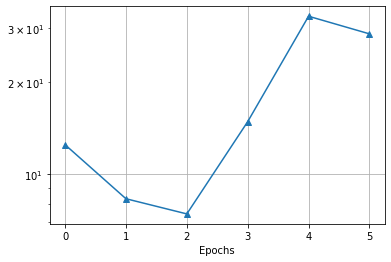

In [33]:
plt.plot(loss_history_end_epoch, "-^")
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)

In [34]:
acc_test, auc_test = test_acc_auc(beta, test_label, test_img_arr)

print(f'Test Accuracy is {acc_test:.2f}')
print(f'Test AUC is {auc_test:.2f}')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 1/t decay

In [ ]:
### To be completed...

## Momentum a.k.a Heavy Ball Method

In [ ]:
### To be completed...